<h1 align="center">🚕</h1>
<h1 align="center">Predicting the Taxi Fare of New York City riders using Machine Learning</h1>

<hr/>
<div align="center">In this notebook, the goal is to predict the New York City Taxi Fare.</div>

## 1. Problem

> How well can we predict the fare amount for a taxi ride in New York City, given the pickup and dropoff locations ?

## 2. Data

The data is downloaded from the Kaggle New York City Taxi Fare Prediction competition:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

There are two main datasets:
- **Train.csv**, the training set, which contains data from January 1, 2009 - June 30, 2015.
- **Test.csv**, the test set, which contains data from January 1, 2009 - June 30, 2015.

## 3. Evaluation

The evaluation metric for this competition is the **RMSE** (root mean-squared error) between the actual and predicted fare amount.

For more on the evaluation on this project check:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

## 4. Features

* **pickup_datetime** - timestamp value indicating when the taxi ride started.
* **pickup_longitude** - float for longitude coordinate of where the taxi ride started.
* **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
* **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
* **passenger_count** - integer indicating the number of passengers in the taxi ride.

<hr/>

In [1]:
# Standard imports

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations

### Get the data

In [2]:
!kaggle competitions download -p datasets/new-york-city-taxi -c new-york-city-taxi-fare-prediction

new-york-city-taxi-fare-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip datasets/new-york-city-taxi/new-york-city-taxi-fare-prediction.zip -d datasets/new-york-city-taxi

Archive:  datasets/new-york-city-taxi/new-york-city-taxi-fare-prediction.zip
replace datasets/new-york-city-taxi/GCP-Coupons-Instructions.rtf? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
NB_ROWS = 20000 # we are sampling the data down to a manageable size which is good to get started

In [5]:
taxi = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS)
taxi.shape

(20000, 8)

### EDA

We will here try to find out more about the data.

#### Copy of the original DataFrame
We make a copy of the original DataFrame so when we manipulate the copy, we've still got our original data.

In [6]:
taxi_origin = taxi.copy()

In [7]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                20000 non-null  object 
 1   fare_amount        20000 non-null  float64
 2   pickup_datetime    20000 non-null  object 
 3   pickup_longitude   20000 non-null  float64
 4   pickup_latitude    20000 non-null  float64
 5   dropoff_longitude  20000 non-null  float64
 6   dropoff_latitude   20000 non-null  float64
 7   passenger_count    20000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,11.303321,-72.478584,39.921043,-72.497221,39.913606,1.658000
std,9.541637,10.525376,6.678592,10.460530,6.139231,1.283674
min,-3.000000,-74.438233,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992150,40.734706,-73.991224,40.734537,1.000000
50%,8.500000,-73.981711,40.752680,-73.980216,40.753583,1.000000
75%,12.500000,-73.966802,40.767443,-73.963729,40.768135,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


Each row represents one taxi ride. There are 6 attributes: 
`pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count`.

All attributes are numerical except `key` and `pickup_datetime` which are objects. As its name indicates it, `pickup_datetime` represents a date. 

#### % of missing values

In [10]:
taxi.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [11]:
taxi_origin.shape, taxi.shape

((20000, 8), (20000, 8))

We notice that none of the attributes has null values except dropoff gps coordonates.

In [12]:
taxi = taxi.dropna(how = 'any', axis = 'rows')

In [13]:
taxi.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

#### Identifying the target attribute

**fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set and this is what we are predicting in the test set.

#### Visualizing the Data

In [14]:
taxi.pickup_datetime[:10]

0    2009-06-15 17:26:21 UTC
1    2010-01-05 16:52:16 UTC
2    2011-08-18 00:35:00 UTC
3    2012-04-21 04:30:42 UTC
4    2010-03-09 07:51:00 UTC
5    2011-01-06 09:50:45 UTC
6    2012-11-20 20:35:00 UTC
7    2012-01-04 17:22:00 UTC
8    2012-12-03 13:10:00 UTC
9    2009-09-02 01:11:00 UTC
Name: pickup_datetime, dtype: object

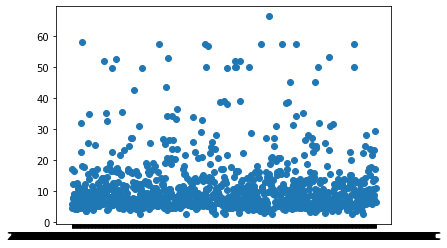

In [15]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

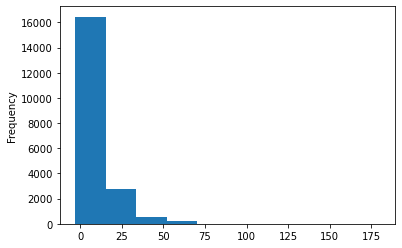

In [16]:
taxi.fare_amount.plot.hist();

In [17]:
taxi.passenger_count.value_counts()

1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64

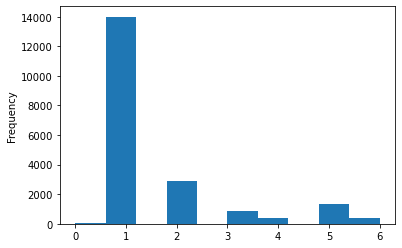

In [18]:
taxi.passenger_count.plot.hist();

#### Visualizing Geographical Data

Since there is geographical information (latitude, longitude), we'll plot the data of all races.

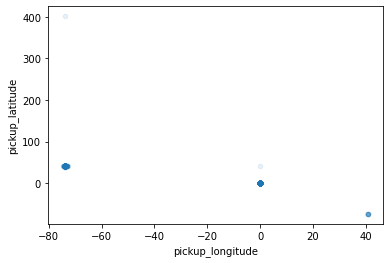

In [19]:
taxi.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1);

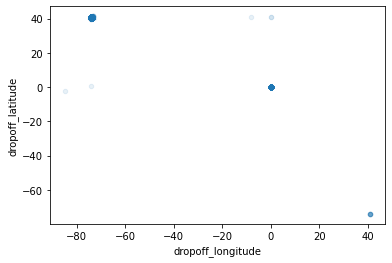

In [20]:
taxi.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", alpha=0.1);

It seems that there is a lot of races in Spain.

#### Studying the correlations between attributes

#### Parsing dates

As we are working with time series data, we want to enrich the time and date component as much as possible.

In [21]:
# We import the data again but we parse dates
taxi = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS,
                  low_memory=False,
                  parse_dates=["pickup_datetime"])

In [22]:
taxi.pickup_datetime.dtype

datetime64[ns, UTC]

In [23]:
taxi.pickup_datetime[:10]

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
5   2011-01-06 09:50:45+00:00
6   2012-11-20 20:35:00+00:00
7   2012-01-04 17:22:00+00:00
8   2012-12-03 13:10:00+00:00
9   2009-09-02 01:11:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

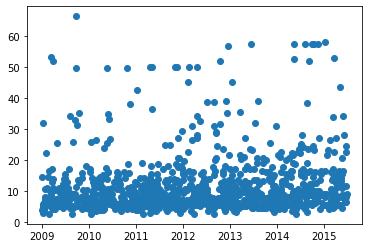

In [24]:
fig, ax = plt.subplots()
ax.scatter(taxi["pickup_datetime"][:1000], taxi["fare_amount"][:1000]);

In [25]:
taxi.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [26]:
taxi.head().T

,0,1,2,3,4
key,2009-06-15 17:26:21.0000001,2010-01-05 16:52:16.0000002,2011-08-18 00:35:00.00000049,2012-04-21 04:30:42.0000001,2010-03-09 07:51:00.000000135
fare_amount,4.500000,16.900000,5.700000,7.700000,5.300000
pickup_datetime,2009-06-15 17:26:21+00:00,2010-01-05 16:52:16+00:00,2011-08-18 00:35:00+00:00,2012-04-21 04:30:42+00:00,2010-03-09 07:51:00+00:00
pickup_longitude,-73.844311,-74.016048,-73.982738,-73.987130,-73.968095
pickup_latitude,40.721319,40.711303,40.761270,40.733143,40.768008
dropoff_longitude,-73.841610,-73.979268,-73.991242,-73.991567,-73.956655
dropoff_latitude,40.712278,40.782004,40.750562,40.758092,40.783762
passenger_count,1,1,2,1,1


In [27]:
# Sort DataFrame in date order
taxi.sort_values(by=["pickup_datetime"], inplace=True, ascending=True)
taxi.pickup_datetime.head(10)

12739   2009-01-01 01:31:49+00:00
17546   2009-01-01 02:05:37+00:00
8684    2009-01-01 02:51:52+00:00
11623   2009-01-01 15:19:00+00:00
10004   2009-01-01 16:52:00+00:00
7756    2009-01-01 17:07:00+00:00
13904   2009-01-01 19:57:19+00:00
16313   2009-01-01 22:40:03+00:00
2354    2009-01-02 02:32:41+00:00
7704    2009-01-02 06:35:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [28]:
# Add datetime parameters for pickup_datetime column
taxi[:1].pickup_datetime.dt.year

12739    2009
Name: pickup_datetime, dtype: int64

In [29]:
taxi[:1].pickup_datetime.dt.day

12739    1
Name: pickup_datetime, dtype: int64

In [30]:
taxi["pickupYear"] = taxi.pickup_datetime.dt.year
taxi["pickupMonth"] = taxi.pickup_datetime.dt.month
taxi["pickupDay"] = taxi.pickup_datetime.dt.day
taxi["pickupDayOfWeek"] = taxi.pickup_datetime.dt.dayofweek
taxi["pickupDayOfYear"] = taxi.pickup_datetime.dt.dayofyear

In [31]:
taxi.head().T

,12739,17546,8684,11623,10004
key,2009-01-01 01:31:49.0000003,2009-01-01 02:05:37.0000004,2009-01-01 02:51:52.0000002,2009-01-01 15:19:00.000000146,2009-01-01 16:52:00.00000053
fare_amount,8.600000,11.000000,10.200000,5.300000,8.500000
pickup_datetime,2009-01-01 01:31:49+00:00,2009-01-01 02:05:37+00:00,2009-01-01 02:51:52+00:00,2009-01-01 15:19:00+00:00,2009-01-01 16:52:00+00:00
pickup_longitude,-73.994192,-73.978433,-73.956172,-73.949937,-73.967647
pickup_latitude,40.720077,40.744781,40.771965,40.784427,40.763077
dropoff_longitude,-73.993356,-74.004713,-73.991027,-73.948735,-73.977438
dropoff_latitude,40.742642,40.734328,40.751035,40.773738,40.787097
passenger_count,1,1,2,5,2
pickupYear,2009,2009,2009,2009,2009
pickupMonth,1,1,1,1,1


In [32]:
taxi.drop("pickup_datetime", axis=1, inplace=True)

## 5. Modeling

We've done some EDA. Let's start to do some **model-driven EDA**.

In [33]:
# Build a machine learning model
model = RandomForestRegressor(n_jobs=1,
                             random_state=42)
model.fit(taxi.drop(["fare_amount"], axis=1), taxi["fare_amount"])

ValueError: could not convert string to float: '2009-01-01 01:31:49.0000003'

In [34]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 12739 to 1428
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                20000 non-null  object 
 1   fare_amount        20000 non-null  float64
 2   pickup_longitude   20000 non-null  float64
 3   pickup_latitude    20000 non-null  float64
 4   dropoff_longitude  20000 non-null  float64
 5   dropoff_latitude   20000 non-null  float64
 6   passenger_count    20000 non-null  int64  
 7   pickupYear         20000 non-null  int64  
 8   pickupMonth        20000 non-null  int64  
 9   pickupDay          20000 non-null  int64  
 10  pickupDayOfWeek    20000 non-null  int64  
 11  pickupDayOfYear    20000 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 2.0+ MB


In [35]:
taxi.isna().sum()

key                  0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
pickupYear           0
pickupMonth          0
pickupDay            0
pickupDayOfWeek      0
pickupDayOfYear      0
dtype: int64

In [36]:
for label, content in taxi.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

fare_amount
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count
pickupYear
pickupMonth
pickupDay
pickupDayOfWeek
pickupDayOfYear


In [37]:
# Check for which numeric columns have null values
for label, content in taxi.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [38]:
# Build a machine learning model
model = RandomForestRegressor(n_jobs=1,
                             random_state=42)
model.fit(taxi.drop(["fare_amount","key"], axis=1), taxi["fare_amount"])



RandomForestRegressor(n_jobs=1, random_state=42)

In [40]:
# Score the model
model.score(taxi.drop(["key","fare_amount"], axis=1), taxi["fare_amount"])

0.9648092903013119